In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [2]:
context_length = 10
learning_rate = 0.01
eval_iters = 10
batch_size=1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
raw_datasets = load_dataset('code_search_net', 'python')
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repository_name'])
# 通过索引提取datasets数据的时候，返回一个dict，其中的value是一个字符串
print(datasets[8]['whole_func_string'])
# 当传入的是一个数组时，返回的依然是一个dict，但其中的value是一个列表
print(datasets[8: 10]['whole_func_string'])

def to_arrow_schema(schema):
    """ Convert a schema from Spark to Arrow
    """
    import pyarrow as pa
    fields = [pa.field(field.name, to_arrow_type(field.dataType), nullable=field.nullable)
              for field in schema]
    return pa.schema(fields)
['def to_arrow_schema(schema):\n    """ Convert a schema from Spark to Arrow\n    """\n    import pyarrow as pa\n    fields = [pa.field(field.name, to_arrow_type(field.dataType), nullable=field.nullable)\n              for field in schema]\n    return pa.schema(fields)', 'def from_arrow_type(at):\n    """ Convert pyarrow type to Spark data type.\n    """\n    import pyarrow.types as types\n    if types.is_boolean(at):\n        spark_type = BooleanType()\n    elif types.is_int8(at):\n        spark_type = ByteType()\n    elif types.is_int16(at):\n        spark_type = ShortType()\n    elif types.is_int32(at):\n        spark_type = IntegerType()\n    elif types.is_int64(at):\n        spark_type = LongType()\n    elif types.is_float3

In [4]:
class char_tokenizer:

    def __init__(self, data, begin_ind=0, end_ind=1):
        # 数据中出现的所有字符构成字典
        chars = sorted(list(set(''.join(data))))
        # 预留两个位置给开头和结尾的特殊字符
        self.char2ind = {s : i + 2 for i, s in enumerate(chars)}
        self.char2ind['<|b|>'] = begin_ind
        self.char2ind['<|e|>'] = end_ind
        self.begin_ind = begin_ind
        self.end_ind = end_ind
        self.ind2char = {i : s for s, i in self.char2ind.items()}

    def encode(self, text):
        return [self.char2ind[c] for c in text]

    def decode(self, enc):
        if isinstance(enc, int):
            return self.ind2char[enc]
        return [self.ind2char[i] for i in enc]

In [5]:
# 举例验证分词器
tok = char_tokenizer(datasets['whole_func_string'])
example_text = 'def postappend(self):'
''.join(tok.decode(tok.encode(example_text))), len(tok.char2ind)

('def postappend(self):', 99)

In [6]:
def autoregressive_trans(text, tokenizer, context_length=context_length):
    inputs, labels = [], []
    b_ind = tokenizer.begin_ind
    e_ind = tokenizer.end_ind
    enc = tokenizer.encode(text)
    # 增加开始和结尾的特殊字符
    x = [b_ind] * context_length + enc + [e_ind]
    for i in range(len(x) - context_length):
        inputs.append(x[i: i + context_length])
        labels.append(x[i + context_length])
    return inputs, labels

# 举例展示自回归模式的训练数据
inputs, labels = autoregressive_trans(example_text, tok)
for a, b in zip(inputs, labels):
    print(''.join(tok.decode(a)), '--->',  tok.decode(b))

<|b|><|b|><|b|><|b|><|b|><|b|><|b|><|b|><|b|><|b|> ---> d
<|b|><|b|><|b|><|b|><|b|><|b|><|b|><|b|><|b|>d ---> e
<|b|><|b|><|b|><|b|><|b|><|b|><|b|><|b|>de ---> f
<|b|><|b|><|b|><|b|><|b|><|b|><|b|>def --->  
<|b|><|b|><|b|><|b|><|b|><|b|>def  ---> p
<|b|><|b|><|b|><|b|><|b|>def p ---> o
<|b|><|b|><|b|><|b|>def po ---> s
<|b|><|b|><|b|>def pos ---> t
<|b|><|b|>def post ---> a
<|b|>def posta ---> p
def postap ---> p
ef postapp ---> e
f postappe ---> n
 postappen ---> d
postappend ---> (
ostappend( ---> s
stappend(s ---> e
tappend(se ---> l
append(sel ---> f
ppend(self ---> )
pend(self) ---> :
end(self): ---> <|e|>


In [7]:
def process(data):
    # 如果是普通的map操作，传入的值是字符串
    # 如果是map操作里面batched=True，传入的值是字符串列表
    text = data['whole_func_string']
    if isinstance(text, str):
        inputs, labels = autoregressive_trans(text, tok)
        return {'inputs': inputs, 'labels': labels}
    inputs, labels = [], []
    for i in text:
        i, l = autoregressive_trans(i, tok)
        inputs += i
        labels += l
    return {'inputs': inputs, 'labels': labels}

process(datasets[8:9])

{'inputs': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 71],
  [0, 0, 0, 0, 0, 0, 0, 0, 71, 72],
  [0, 0, 0, 0, 0, 0, 0, 71, 72, 73],
  [0, 0, 0, 0, 0, 0, 71, 72, 73, 3],
  [0, 0, 0, 0, 0, 71, 72, 73, 3, 87],
  [0, 0, 0, 0, 71, 72, 73, 3, 87, 82],
  [0, 0, 0, 71, 72, 73, 3, 87, 82, 66],
  [0, 0, 71, 72, 73, 3, 87, 82, 66, 68],
  [0, 71, 72, 73, 3, 87, 82, 66, 68, 85],
  [71, 72, 73, 3, 87, 82, 66, 68, 85, 85],
  [72, 73, 3, 87, 82, 66, 68, 85, 85, 82],
  [73, 3, 87, 82, 66, 68, 85, 85, 82, 90],
  [3, 87, 82, 66, 68, 85, 85, 82, 90, 66],
  [87, 82, 66, 68, 85, 85, 82, 90, 66, 86],
  [82, 66, 68, 85, 85, 82, 90, 66, 86, 70],
  [66, 68, 85, 85, 82, 90, 66, 86, 70, 75],
  [68, 85, 85, 82, 90, 66, 86, 70, 75, 72],
  [85, 85, 82, 90, 66, 86, 70, 75, 72, 80],
  [85, 82, 90, 66, 86, 70, 75, 72, 80, 68],
  [82, 90, 66, 86, 70, 75, 72, 80, 68, 11],
  [90, 66, 86, 70, 75, 72, 80, 68, 11, 86],
  [66, 86, 70, 75, 72, 80, 68, 11, 86, 70],
  [86, 70, 75, 72, 80, 68, 11, 86, 70, 75],

In [8]:
tokenized = datasets.train_test_split(test_size=0.1, seed=1024, shuffle=True)
tokenized = tokenized.map(process, batched=True, remove_columns=datasets.column_names)
tokenized.set_format(type='torch', device=device)

tokenized['train']['inputs'].shape, tokenized['train']['labels'].shape

(torch.Size([645401, 10]), torch.Size([645401]))

In [9]:
# 构建数据读取器
train_loader = DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tokenized['test'], batch_size=batch_size, shuffle=True)
# 获取一个批量的数据
next(iter(test_loader))

{'inputs': tensor([[38, 85, 72,  ..., 12,  2,  3],
         [ 3, 76, 73,  ..., 86, 87, 66],
         [80, 72, 15,  ..., 75, 15,  3],
         ...,
         [75, 76, 86,  ..., 79,  3, 68],
         [87, 68, 81,  ..., 82, 90, 15],
         [ 3,  3,  3,  ..., 68, 85, 68]], device='cuda:0'),
 'labels': tensor([ 3, 86, 86, 90, 72, 87,  3, 81, 76, 29, 74, 87, 87, 87, 71,  3,  3,  3,
         15,  3, 68,  3, 87, 75, 86, 17, 75, 13,  3, 80,  3, 83, 86, 68,  3, 83,
          3, 81, 53, 83, 11, 66,  3, 85, 85, 82, 76, 85, 73, 14,  3, 75,  3,  3,
         88,  3,  3,  3, 79, 82,  3, 50, 58, 11, 17,  3, 86, 93,  3, 87,  3, 74,
         78, 78, 80, 54,  3,  2, 81, 80,  3, 81,  3,  3, 74,  3, 76, 82, 82,  3,
         60, 12,  5, 73, 75, 72, 87,  3, 66, 73, 69, 85,  3, 76,  3,  3,  3, 86,
         87, 72,  2,  3, 70, 85,  3,  3, 72, 32,  3,  3, 68,  3, 79, 72, 88,  3,
         70, 76, 11,  3, 80, 72,  3, 87, 71,  3, 76, 73, 11, 82,  8, 84,  3, 72,
          3, 76,  3, 49, 79, 87,  3,  3, 73, 12, 79, 

In [10]:
class CharMLP(nn.Module):

    def __init__(self, vs):
        super().__init__()
        self.embedding = nn.Embedding(vs, 30)
        self.hidden1 = nn.Linear(300, 200)
        self.hidden2 = nn.Linear(200, 100)
        self.out = nn.Linear(100, vs)

    def forward(self, x):
        B = x.shape[0]               # (B,  10)
        emb = self.embedding(x)      # (B,  10, 30)
        h = emb.view(B, -1)          # (B, 300)
        h = F.relu(self.hidden1(h))  # (B, 200)
        h = F.relu(self.hidden2(h))  # (B, 100)
        h = self.out(h)              # (B,  vs)
        return h

model = CharMLP(len(tok.char2ind)).to(device)

In [11]:
@torch.no_grad()
def generate(model, context, max_new_tokens=300):
    out = []
    # 将模型切换至评估模式
    model.eval()
    for _ in range(max_new_tokens):
        logits = model(context)
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1)
        # 利用模型的预测结果更新文本背景
        context = torch.cat((context[:, 1:], ix), dim=1)
        out.append(ix.item())
        if ix.item() == tok.end_ind:
            break
    # 将模型切换至训练模式
    model.train()
    return out

In [12]:
context = torch.zeros((1, 10), dtype=torch.long, device=device)
print(''.join(tok.decode(generate(model, context))))

)YN'E.ne'!XOzAYD
F{tvö290&^#>P8(MZzJP<BJe@L9hJb`Q:*P2i;r@dfVR#L/sw pxS2!xLl4Y`(&V}\[Vl%A!'zq<|e|>


In [13]:
def estimate_loss(model):
    re = {}
    # 将模型切换至评估模式
    model.eval()
    _train = lambda: next(iter(train_loader))
    re['train'] = _loss(model, _train)
    _test = lambda: next(iter(test_loader))
    re['test'] = _loss(model, _test)
    # 将模型切换至训练模式
    model.train()
    return re

@torch.no_grad()
def _loss(model, data_loader):
    """
    计算模型在不同数据集下面的评估指标
    """
    loss = []
    for k in range(eval_iters):
        data = data_loader()
        inputs, labels = data['inputs'], data['labels']
        logits = model(inputs)
        loss.append(F.cross_entropy(logits, labels).item())
    return torch.tensor(loss).mean().item()

estimate_loss(model)

{'train': 4.596782684326172, 'test': 4.594883918762207}

In [14]:
def train_mlp(model, optimizer, data_loader, epochs=10):
    lossi = []
    for epoch in range(epochs):
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data['inputs'], data['labels']
            optimizer.zero_grad()
            logits = model(inputs)
            loss = F.cross_entropy(logits, labels)
            lossi.append(loss.item())
            loss.backward()
            optimizer.step()
        # 评估模型，并输出结果
        stats = estimate_loss(model)
        train_loss = f'train loss {stats["train"]:.4f}'
        test_loss = f'test loss {stats["test"]:.4f}'
        print(f'epoch {epoch:>2}: {train_loss}, {test_loss}')
    return lossi

In [15]:
l = train_mlp(model, optim.Adam(model.parameters(), lr=learning_rate), train_loader)

epoch  0: train loss 1.3092, test loss 1.4971
epoch  1: train loss 1.2202, test loss 1.4287
epoch  2: train loss 1.1897, test loss 1.3987
epoch  3: train loss 1.1320, test loss 1.3873
epoch  4: train loss 1.1228, test loss 1.3779
epoch  5: train loss 1.1089, test loss 1.3508
epoch  6: train loss 1.0824, test loss 1.3818
epoch  7: train loss 1.1002, test loss 1.3723
epoch  8: train loss 1.0797, test loss 1.3462
epoch  9: train loss 1.0516, test loss 1.3164


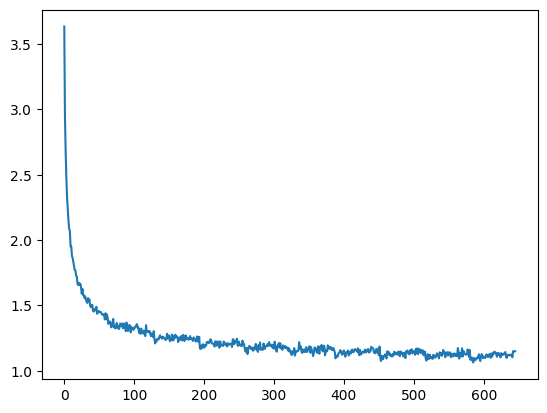

In [16]:
plt.plot(torch.tensor(l).view(-1, 10).mean(1).numpy())

In [17]:
context = torch.zeros((1, 10), dtype=torch.long, device=device)
print(''.join(tok.decode(generate(model, context))))

def ganewT("_1.-67))).ST}4 bhethodd the alrizer the s the firstencers: the clias
        # The festeplageType
        return Build name schema)

        Yor panddaate_byte
        for specified.
        :param cols: usible self.sql_ctx.rand_rec_fies = seed is a sample dataset onceoref looage_check_d
